# Gaussian Process Taste-test

The scikit-learn package has a nice Gaussian Process demo. First we run that, and then try to do the same thing by-hand with numpy/scipy. Finally, let's use GPy to compare a few kernels.

## Super brief introduction and key equations
Let us look at the basics of Gaussian Processes in one dimension. See Rasmussen and Williams for a great, pedagogically smooth introduction to Gaussian Processes that will teach you everything you will need to get started.

We denote $\vec{x}=(x_0, \dots, x_N)$ a vector of 1D input values. A 1D Gaussian process $f$ is such that
$f \sim \mathcal{GP} \ \Longleftrightarrow \ p(f(\vec{x}), f(\vec{x}'))\ \mathrm{is\ Gaussian} \ \forall \vec{x}, \vec{x}'$.

It is fully characterized by a mean function and a kernel,
$$\begin{eqnarray*}m(\vec{x}) &=& \mathbb{E}[ f(\vec{x}) ]\\
k(\vec{x}, \vec{x}') &=& \mathbb{E}[ (f(\vec{x})-m(\vec{x}))(f(\vec{x}')-m(\vec{x}')) ]\end{eqnarray*}$$

Let us consider a noisy dataset $(\vec{x},\vec{y})$ with Gaussian homoskedastic errors $\epsilon$ that are Gaussian with std deviation $\sigma$. Fitting a Gaussian Process to it is equivalent to considering a set of basis functions $\{\phi_i(x)\}$ and finding the optimal weights $\{\omega_i\}$, which we assume to be Gaussian we some covariance $\Sigma$.
$$\begin{eqnarray*}
\vec{y} &=& f(\vec{x}) + \vec{\epsilon}\\
\vec{\epsilon} &\sim & \mathcal{N}(0,\sigma I)\\
f(\vec{x}) &=& \sum_i \omega_i \phi_i(\vec{x}) = \vec{\omega}^T\vec{\phi}(\vec{x}) \\
\vec{\omega} &\sim & \mathcal{N}(0,\Sigma)\\
\end{eqnarray*}$$

In this case, the mean function is assumed to be zero, $m(\vec{x}) = 0$, which is not actually very constraining (see Rasmussen and Williams; this is not equivalent to assuming that the mean of $f$ is zero). Importantly, the kernel is fully characterized by the choise of basis functions,
$$\quad k(\vec{x},\vec{x}') = \vec{\phi}(\vec{x})^T \Sigma\ \vec{\phi}(\vec{x}')$$
Picking a set of basic function is equivalent to picking a kernel, and conversely.

Let's assume that we have found these weights, i.e. that we have fitted $(\vec{x},\vec{y})$. Let's use the Gaussian Process and evaluate it at new inputs $\vec{x}^*$. Thanks to the magic of Gaussian distributions and linear algebra, one can show that the posterior distribution for the process evaluated at new inputs $\vec{x}^*$ given a fit to the existing values $(\vec{x},\vec{y})$ is also Gaussian,
$$p( f(\vec{x}^*) | \vec{y}, \vec{x}, \vec{x}^* ) \ \sim \  \mathcal{N}(\bar{f}, \bar{k})$$

The mean of this distribution is 
$$\bar{f} \ =\  k(\vec{x}^*,\vec{x})[k(\vec{x},\vec{x}) + \sigma I]^{-1} \vec{y}$$
and its covariance reads
$$\bar{k} = k(\vec{x}^*,\vec{x}^*) - k(\vec{x},\vec{x}^*) [k(\vec{x},\vec{x}) + \sigma I]^{-1}k(\vec{x},\vec{x}^*)^T  $$

That's it! The prediction $\bar{f}$ is linear in the inputs $y$, which is quite remarkable. Note that we haven't explicitly found the weights. Once the kernel is chosen, one can fit the data and make prediction for new data. Note that multiple matrix inversions and multiplications are involved, so Gaussian Processes can be very expensive. 

This is all the maths you need to run Gaussian Processes. Here is a list of more advanced topics that you should think about if you apply Gaussian Processes to real data:

- Generalizing to multiple input dimensions (keeping one output dimension) is trivial, but the case of multiple outputs is not (partly because it is less natural). 
- Choosing a physically motivated kernel or a kernel that simplifies the computation, for example by yielding sparse matrices.
- Parametrizing the kernel and/or the mean function and inferring these hyperparameters from the data.
- Using a small fraction of the data to make predictions. This is referred to as Sparse Gaussian Processes. Finding an optimal "summary" subset of the data is key.
- Gaussian Processes natively work with Gaussian noise / likelihood functions. With non-Gaussian cases, some analytical results are no longer valid (e.g. the marginal likelihood) but approximations exist.
- What if the inputs $\vec{x}$ have uncertainties? There are various way to deal with this, but this is much more intensive than normal Gaussian Processes.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

## Make Some Data

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

def make_data(N, rseed=1):
    np.random.seed(rseed)

    # Create some observations with noise
    X = np.random.uniform(low=0.1, high=9.9, size=N)
    X = np.atleast_2d(X).T

    y = f(X).ravel()
    dy = 0.5 + 1.0 * np.random.random(y.shape)
    noise = np.random.normal(0, dy)
    y += noise
    
    return X, y, dy

X, y, dy = make_data(20)

## Gaussian Process Regression with Scikit-Learn

Example adapted from [Scikit-learn's Examples](http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)

In [3]:
# Get the master version of scikit-learn; new GP code isn't in release
# This needs to compile things, so it will take a while...
# Uncomment the following:

# !pip install git+git://github.com/scikit-learn/scikit-learn.git

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential
from sklearn.gaussian_process.kernels import ConstantKernel as Amplitude

# Instanciate a Gaussian Process model
kernel = Amplitude(1.0, (1E-3, 1E3)) * SquaredExponential(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=(dy / y)**2,  # fractional errors in data
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

GaussianProcessRegressor(alpha=array([  2.81880e-01,   1.06665e-01,   8.21349e+01,   1.85751e+00,
         1.38706e+00,   7.71353e-01,   1.74396e-01,   1.49819e-01,
         3.77392e-02,   6.54060e-02,   2.14450e-02,   7.14823e-02,
         6.34041e+01,   2.98751e-02,   3.18792e-01,   6.80960e-02,
         9.46038e-02,   7.69771e-02,   2.29495e-01,   1.00917e-01]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [5]:
gp.kernel_

3.69**2 * RBF(length_scale=0.887)

In [6]:
# note: gp.kernel is the initial kernel
#       gp.kernel_ (with an underscore) is the fitted kernel
gp.kernel_.get_params()

{'k1': 3.69**2,
 'k1__constant_value': 13.646552048519276,
 'k1__constant_value_bounds': (0.001, 1000.0),
 'k2': RBF(length_scale=0.887),
 'k2__length_scale': 0.88652850735084876,
 'k2__length_scale_bounds': (0.01, 100.0)}

In [7]:
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x_pred = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_pred, return_std=True)

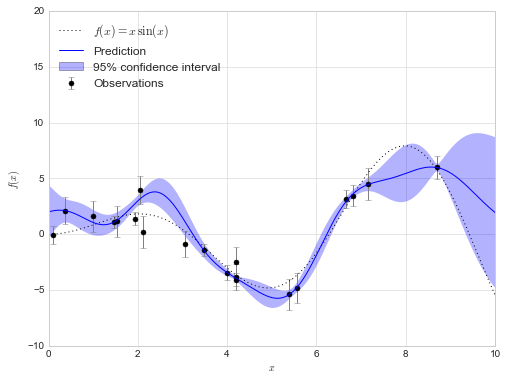

In [8]:
def plot_results(X, y, dy, x_pred, y_pred, sigma):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(x_pred, f(x_pred), 'k:', label=u'$f(x) = x\,\sin(x)$')
    plt.errorbar(X.ravel(), y, dy, fmt='k.', markersize=10, label=u'Observations',
                 ecolor='gray')
    plt.plot(x_pred, y_pred, 'b-', label=u'Prediction')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left');
    
plot_results(X, y, dy, x_pred, y_pred, sigma)

## Gaussian Processes by-hand

Let us run the same example but solving the Gaussian Process equations by hand.
Let's use the kernel constructed with scikit-learn (because its parameters are optimized)
And let's compute the Gaussian process manually using Scipy linalg

In [9]:
import scipy.linalg
KXX = gp.kernel_(X)
A = KXX + np.diag((dy/y)**2.)
L = scipy.linalg.cholesky(A, lower=True)
KXXp = gp.kernel_(x_pred, X)
KXpXp = gp.kernel_(x_pred)
alpha = scipy.linalg.cho_solve((L, True), y)
y_pred = np.dot(KXXp, alpha) + np.mean(y, axis=0)
v = scipy.linalg.cho_solve((L, True), KXXp.T)
y_pred_fullcov = KXpXp - KXXp.dot(v)
sigma = np.sqrt(np.diag(y_pred_fullcov))

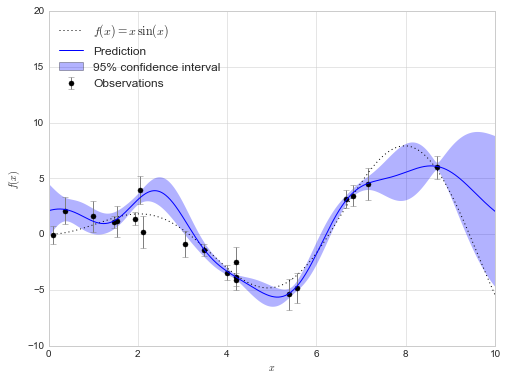

In [10]:
plot_results(X, y, dy, x_pred, y_pred, sigma) 

## Quick kernel comparison with GPy
Let's now use the GPy package and compare a couple of kernels applied to our example.
We'll optimize the parameters in each case. We not only plot the mean and std dev of the process
but also a few samples. As you can see, they look very different, and the choice of kernel is critical! 

 /Users/bl/anaconda/lib/python2.7/site-packages/GPy/core/gp.py:488: RuntimeWarning:covariance is not positive-semidefinite.


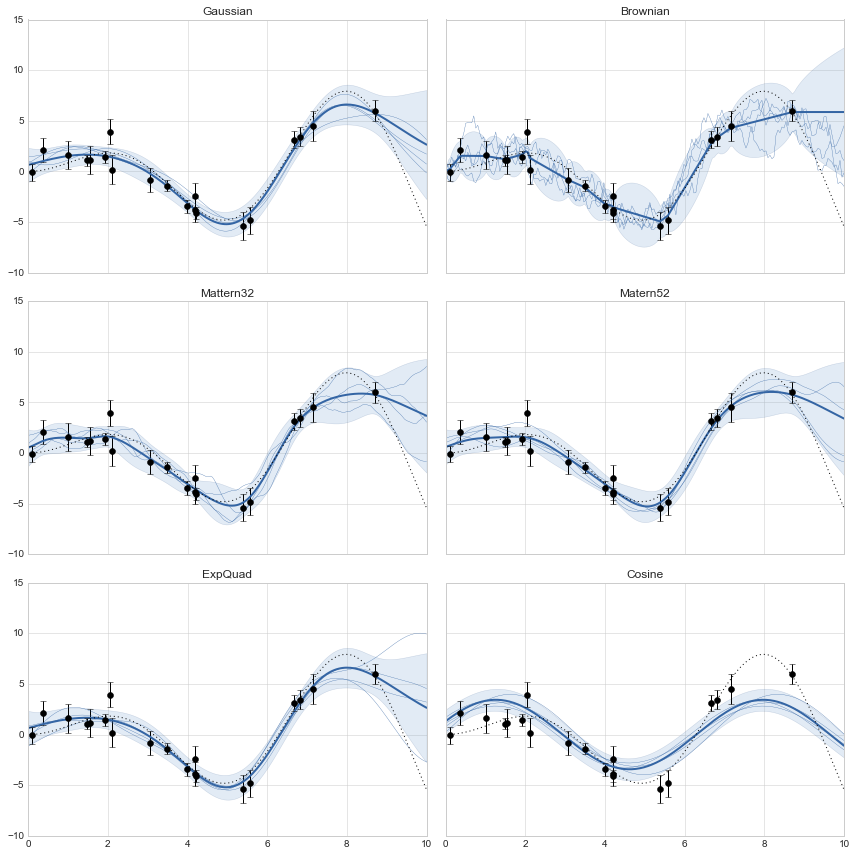

In [11]:
import GPy

kernels = [GPy.kern.RBF(input_dim=1),
           GPy.kern.Brownian(input_dim=1),
          GPy.kern.Matern32(input_dim=1),
          GPy.kern.Matern52(input_dim=1),
          GPy.kern.ExpQuad(input_dim=1),
          GPy.kern.Cosine(input_dim=1)]
names = ['Gaussian', 'Brownian', 'Mattern32', 'Matern52', 'ExpQuad', 'Cosine']

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, k in enumerate(kernels):
    m = GPy.models.GPRegression(X, y[:,None], kernel=k)
    m.optimize()
    m.plot_f(ax=axs[i], plot_data=True, samples=4, legend=False, plot_limits=[0, 10]) 
    # plotting four samples of the GP posterior too
    axs[i].errorbar(X, y, yerr=dy, fmt="o", c='k')
    axs[i].set_title(names[i])
    axs[i].plot(x_pred, f(x_pred), 'k:', label=u'$f(x) = x\,\sin(x)$')
fig.tight_layout()